# Reading groundwater observations

This notebook introduces how to use the `hydropandas` package to read, process and visualise groundwater data from Dino and Bro databases.

## <a id=top></a>Notebook contents

1. [GroundwaterObs](#GroundwaterObs)
2. [ObsCollection](#ObsCollection)
3. [Read ObsCollections](#readingOC)
4. [Write ObsCollections](#writeOC)

In [1]:
import hydropandas as hpd

import logging
from IPython.display import HTML

import logging

In [2]:
hpd.util.get_color_logger("INFO");

## GroundwaterObs<a id=GroundwaterObs></a>

The hydropandas package has several functions to read groundwater observations at a measurement well. These include reading data from:
- dino (from csv-files).
- bro (using the bro-api)
- fews (xml dumps from the fews database)
- wiski (dumps from the wiski database)

In [3]:
# reading a dino csv file
fname = "data/Grondwaterstanden_Put/B33F0080001_1.csv"
gw_dino = hpd.GroundwaterObs.from_dino(fname=fname)

INFO:hydropandas.io.dino:reading -> B33F0080001_1


In [4]:
# reading the same filter from using the bro api. Specify a groundwater monitoring id (GMW00...) and a filter number (1)
gw_bro = hpd.GroundwaterObs.from_bro("GMW000000041261", 1)

INFO:hydropandas.io.bro:reading bro_id GMW000000041261
INFO:hydropandas.io.bro:GLD000000009378 contains 36 duplicates (of 66447). Keeping only first values.


Now we have an `GroundwaterObs` object named `gw_bro` and `gw_dino`. Both objects are from the same measurement well in different databases. A `GroundwaterObs` object inherits from a pandas `DataFrame` and has the same attributes and methods.

In [5]:
gw_bro.describe()

,values
count,66411.000000
mean,5.562630
std,0.222262
min,4.913000
25%,5.380000
50%,5.569000
75%,5.721000
max,6.397000


In [6]:
gw_bro

,values,qualifier
1972-11-28 00:00:00,5.763,goedgekeurd
1972-12-07 00:00:00,5.773,goedgekeurd
1972-12-14 00:00:00,5.703,goedgekeurd
1972-12-21 00:00:00,5.643,goedgekeurd
1972-12-28 00:00:00,5.573,goedgekeurd
...,...,...
2021-10-08 07:00:00,5.486,goedgekeurd
2021-10-08 08:00:00,5.485,goedgekeurd
2021-10-08 09:00:00,5.486,goedgekeurd
2021-10-08 09:47:00,5.491,goedgekeurd


Text(0.5, 1.0, 'same tube from Dinoloket B33F0080-001 and BRO id GMW000000041261_1')

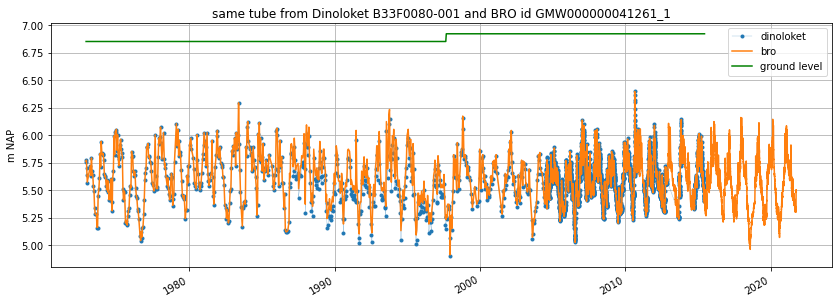

In [7]:
ax = gw_dino["stand_m_tov_nap"].plot(
    label="dinoloket", figsize=(14, 5), legend=True, marker=".", lw=0.2
)
gw_bro["values"].plot(ax=ax, label="bro", legend=True, ylabel=gw_bro.unit)
gw_dino["ground_level"].plot(
    ax=ax,
    label="ground level",
    legend=True,
    grid=True,
    color="green",
    ylabel=gw_dino.unit,
)

ax.set_title(f"same tube from Dinoloket {gw_dino.name} and BRO id {gw_bro.name}");

#### GroundwaterObs Attributes

Besides the standard `DataFrame` attributes a `GroundwaterObs` has the following additional attributes:
- x, y: x- and y-coordinates of the observation point
- name: str with the name
- filename: str with the filename (only available when the data was loaded from a file)
- monitoring_well: the name of the monitoring_well. One monitoring well can have multiple tubes.
- tube_nr: the number of the tube. The combination of monitoring_well and tube_nr should be unique
- screen_top: the top of the tube screen (bovenkant filter in Dutch)
- screen_bottom: the bottom of the tube screen (onderkant filter in Dutch)
- ground_level: surface level (maaiveld in Dutch)
- tube_top: the top of the tube
- metadata_available: boolean indicating whether metadata is available for this observation point
- meta: dictionary with additional metadata

When dowloading from Dinoloket all levels are in meters NAP.

In [8]:
print(gw_bro)

GroundwaterObs GMW000000041261_1
-----metadata------
name : GMW000000041261_1 
x : 213268.0 
y : 473910.0 
filename :  
source : BRO 
unit : m NAP 
monitoring_well : GMW000000041261 
tube_nr : 1 
screen_top : 4.05 
screen_bottom : 3.05 
ground_level : 6.9 
tube_top : 7.173 
metadata_available : True 

-----time series------
                     values    qualifier
1972-11-28 00:00:00   5.763  goedgekeurd
1972-12-07 00:00:00   5.773  goedgekeurd
1972-12-14 00:00:00   5.703  goedgekeurd
1972-12-21 00:00:00   5.643  goedgekeurd
1972-12-28 00:00:00   5.573  goedgekeurd
...                     ...          ...
2021-10-08 07:00:00   5.486  goedgekeurd
2021-10-08 08:00:00   5.485  goedgekeurd
2021-10-08 09:00:00   5.486  goedgekeurd
2021-10-08 09:47:00   5.491  goedgekeurd
2021-10-08 10:00:00   5.485  goedgekeurd

[66411 rows x 2 columns]


#### GroundwaterObs methods

Besides the standard `DataFrame` methods a `GroundwaterObs` has additional methods. This methods are accessible through submodules:
- `geo.get_lat_lon()`, to obtain latitude and longitude
- `gwobs.get_modellayer()`, to obtain the modellayer of a modflow model using the filter depth
- `stats.get_seasonal_stat()`, to obtain seasonal statistics
- `stats.obs_per_year()`, to obtain the number of observations per year
- `stats.consecutive_obs_years()`, to obtain the number of consecutive years with more than a minimum number of observations
- `plots.interactive_plot()`, to obtain a bokeh plot





Get latitude and longitude with `gw.geo.get_lat_lon()`:

In [9]:
print(f"latitude and longitude -> {gw_bro.geo.get_lat_lon()}")

latitude and longitude -> (52.25014706738195, 6.24047994529121)


In [10]:
gw_bro.stats.get_seasonal_stat(stat="mean")

,winter_mean,summer_mean
GMW000000041261_1,5.723791,5.40682


In [11]:
p = gw_bro.plots.interactive_plot("figure")
HTML(filename="figure/{}.html".format(gw_bro.name))

## ObsCollections<a id=ObsCollections></a>

`ObsCollections` are a combination of multiple observation objects. The easiest way to construct an `ObsCollections` is from a list of observation objects.

In [12]:
fname1 = "data/Grondwaterstanden_Put/B33F0080001_1.csv"
fname2 = "data/Grondwaterstanden_Put/B33F0133001_1.csv"
gw1 = hpd.GroundwaterObs.from_dino(fname=fname1)
gw2 = hpd.GroundwaterObs.from_dino(fname=fname2)

# create ObsCollection
oc = hpd.ObsCollection([gw1, gw2], name="Dino groundwater")
oc

INFO:hydropandas.io.dino:reading -> B33F0080001_1
INFO:hydropandas.io.dino:reading -> B33F0133001_1


,x,y,filename,source,unit,monitoring_well,tube_nr,screen_top,screen_bottom,ground_level,tube_top,metadata_available,obs
name,,,,,,,,,,,,,
B33F0080-001,213260.0,473900.0,B33F0080001_1,dino,m NAP,B33F0080,1.0,3.85,2.85,6.92,7.18,True,GroundwaterObs B33F0080-001 -----metadata-----...
B33F0133-001,210400.0,473366.0,B33F0133001_1,dino,m NAP,B33F0133,1.0,-67.50,-70.00,6.50,7.14,True,GroundwaterObs B33F0133-001 -----metadata-----...


Now we have an `ObsCollection` object named `oc`. The `ObsCollection` contains all the data from the two `GroundwaterObs` objects. It also stores a reference to the `GroundwaterObs` objects in the 'obs' column. An `ObsCollection` object also inherits from a pandas `DataFrame` and has the same attributes and methods.

In [13]:
# get columns
oc.columns

Index(['x', 'y', 'filename', 'source', 'unit', 'monitoring_well', 'tube_nr',
       'screen_top', 'screen_bottom', 'ground_level', 'tube_top',
       'metadata_available', 'obs'],
      dtype='object')

In [14]:
# get individual GroundwaterObs object from an ObsCollection
o = oc.loc["B33F0133-001", "obs"]
o

,stand_m_tov_nap,locatie,filternummer,stand_cm_tov_mp,stand_cm_tov_mv,stand_cm_tov_nap,bijzonderheid,opmerking,tube_top
1989-12-14,1.20,B33F0133,1,582.0,530.0,120.0,NaN,NaN,7.02
1990-01-15,1.57,B33F0133,1,545.0,493.0,157.0,NaN,NaN,7.02
1990-01-29,1.70,B33F0133,1,532.0,480.0,170.0,NaN,NaN,7.02
1990-02-14,1.53,B33F0133,1,549.0,497.0,153.0,NaN,NaN,7.02
1990-03-01,1.56,B33F0133,1,546.0,494.0,156.0,NaN,NaN,7.02
...,...,...,...,...,...,...,...,...,...
2011-01-14,3.57,B33F0133,1,357.0,293.0,357.0,NaN,NaN,7.14
2011-01-15,3.60,B33F0133,1,354.0,290.0,360.0,NaN,NaN,7.14
2011-01-16,3.61,B33F0133,1,353.0,289.0,361.0,NaN,NaN,7.14
2011-01-17,3.61,B33F0133,1,353.0,289.0,361.0,NaN,NaN,7.14


In [15]:
# get statistics
oc.describe()

,x,y,tube_nr,screen_top,screen_bottom,ground_level,tube_top
count,2.000000,2.000000,2.0,2.000000,2.000000,2.000000,2.000000
mean,211830.000000,473633.000000,1.0,-31.825000,-33.575000,6.710000,7.160000
std,2022.325394,377.595021,0.0,50.452069,51.512729,0.296985,0.028284
min,210400.000000,473366.000000,1.0,-67.500000,-70.000000,6.500000,7.140000
25%,211115.000000,473499.500000,1.0,-49.662500,-51.787500,6.605000,7.150000
50%,211830.000000,473633.000000,1.0,-31.825000,-33.575000,6.710000,7.160000
75%,212545.000000,473766.500000,1.0,-13.987500,-15.362500,6.815000,7.170000
max,213260.000000,473900.000000,1.0,3.850000,2.850000,6.920000,7.180000


#### ObsCollection methods
Besides the methods of a pandas `DataFrame` an `ObsCollection` has additional methods stored in submodules.

`geo`:
- `get_bounding_box` -> get a tuple with (xmin, ymin, xmax, ymax)
- `get_extent` -> get a tule with (xmin, xmax, ymin, ymax)
- `get_lat_lon` -> to get the lattitudes and longitudes from the x and y coordinates
- `within_polygon` -> to select only the observations that lie within a polygon

`gwobs`:
- `set_tube_nr` -> to set the tube numbers based on the tube screen depth when there are multiple tubes at one monitoring well
- `set_tube_nr_monitoring_well` -> find out which observations are at the same location with a different screen depth. Set monitoring_well and tube_nr attributes accordingly.

`plots`:
- `interactive_figures` -> create bokeh figures for each observation point.
- `interactive_map` -> create a folium map with observation points and bokeh figures for each observation point.
- `section_plot` -> create a plot of multiple observations and a plot of the well layout.

`stats`:
- `get_first_last_obs_date()` -> get the first and the last date of the observations for each observation point
- `get_no_of_observations()` -> get the number of observations
- `get_seasonal_stat()` -> get seasonal stats of the observations

E.g. get the bounding box with `gw.geo.get_bounding_box()`:

In [16]:
print(f"bounding box -> {oc.geo.get_bounding_box()}")

bounding box -> (210400.0, 473366.0, 213260.0, 473900.0)


In [17]:
oc.geo.set_lat_lon()
oc.plots.interactive_map(plot_dir="figure")

We can get an overview of the well layout and observations via `plots.section_plot`:

INFO:hydropandas.extensions.plots:created sectionplot -> B33F0133-001


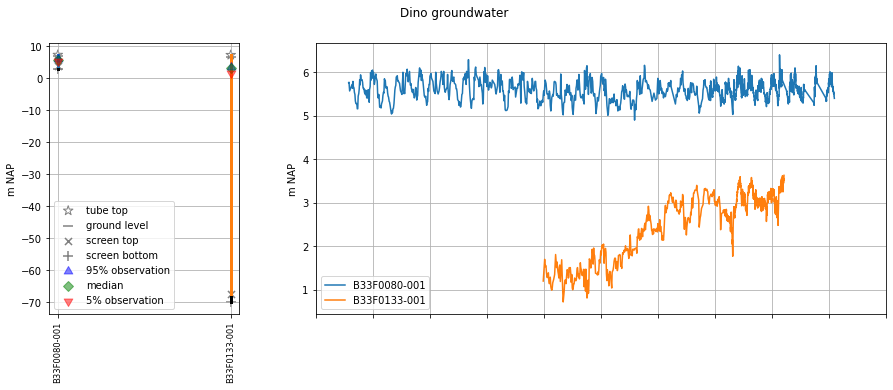

In [18]:
oc.plots.section_plot();

#### ObsCollection Attributes

An `ObsCollection` also has additional attributes:
- name, a str with the name of the collection
- meta, a dictionary with additional metadata

In [19]:
print(f"name is -> {oc.name}")
print(f"meta is -> {oc.meta}")

name is -> Dino groundwater
meta is -> {}


## Read ObsCollections<a id=readingOC></a>

Instead of creating the ObsCollection from a list of observation objects. It is also possible to read the data from a source into an ObsCollection at once. The following sources can be read as an ObsCollection:

- bro (using the api)
- dino (from files)
- fews (dumps from the fews database)
- wiski (dumps from the wiski database)
- menyanthes (a .men file)
- modflow (from the heads of a modflow model)
- imod (from the heads of an imod model)

This notebook won't go into detail on all the sources that can be read. Only the two options for reading data from Dino and BRO are shown below.

In [21]:
# read using a .zip file with data
dinozip = "data/dino.zip"
dino_gw = hpd.read_dino(dirname=dinozip, keep_all_obs=False)
dino_gw

INFO:hydropandas.io.dino:reading -> 
INFO:hydropandas.io.dino:reading -> 
INFO:hydropandas.io.dino:reading -> 
INFO:root:not added to collection -> <_io.TextIOWrapper name='Grondwaterstanden_Put/B04D0032002_1.csv' encoding='UTF-8'>
INFO:hydropandas.io.dino:reading -> 
INFO:root:not added to collection -> <_io.TextIOWrapper name='Grondwaterstanden_Put/B27D0260001_1.csv' encoding='UTF-8'>
INFO:hydropandas.io.dino:reading -> 
INFO:hydropandas.io.dino:reading -> 
INFO:hydropandas.io.dino:reading -> 
INFO:hydropandas.io.dino:reading -> 
INFO:hydropandas.io.dino:reading -> 
INFO:root:not added to collection -> <_io.TextIOWrapper name='Grondwaterstanden_Put/B37A0112001_1.csv' encoding='UTF-8'>
INFO:hydropandas.io.dino:reading -> 
INFO:hydropandas.io.dino:reading -> 
INFO:hydropandas.io.dino:reading -> 
INFO:hydropandas.io.dino:reading -> 
INFO:hydropandas.io.dino:reading -> 
INFO:hydropandas.io.dino:reading -> 
INFO:hydropandas.io.dino:reading -> 
INFO:hydropandas.io.dino:reading -> 
INFO:hyd

,x,y,filename,source,unit,monitoring_well,tube_nr,screen_top,screen_bottom,ground_level,tube_top,metadata_available,obs
name,,,,,,,,,,,,,
B02H0092-001,219890.0,600030.0,,dino,m NAP,B02H0092,1.0,NaN,NaN,NaN,NaN,True,GroundwaterObs B02H0092-001 -----metadata-----...
B02H1007-001,219661.0,600632.0,,dino,m NAP,B02H1007,1.0,NaN,NaN,1.92,NaN,True,GroundwaterObs B02H1007-001 -----metadata-----...
B33F0080-001,213260.0,473900.0,,dino,m NAP,B33F0080,1.0,3.85,2.85,6.92,7.18,True,GroundwaterObs B33F0080-001 -----metadata-----...
B33F0080-002,213260.0,473900.0,,dino,m NAP,B33F0080,2.0,-10.15,-12.15,6.92,7.17,True,GroundwaterObs B33F0080-002 -----metadata-----...
B33F0133-001,210400.0,473366.0,,dino,m NAP,B33F0133,1.0,-67.50,-70.00,6.50,7.14,True,GroundwaterObs B33F0133-001 -----metadata-----...
B33F0133-002,210400.0,473366.0,,dino,m NAP,B33F0133,2.0,-104.20,-106.20,6.50,7.12,True,GroundwaterObs B33F0133-002 -----metadata-----...
B42B0003-001,38165.0,413785.0,,dino,m NAP,B42B0003,1.0,-2.00,-3.00,6.50,6.99,True,GroundwaterObs B42B0003-001 -----metadata-----...
B42B0003-002,38165.0,413785.0,,dino,m NAP,B42B0003,2.0,-34.00,-35.00,6.50,6.99,True,GroundwaterObs B42B0003-002 -----metadata-----...
B42B0003-003,38165.0,413785.0,,dino,m NAP,B42B0003,3.0,-60.00,-61.00,6.50,6.95,True,GroundwaterObs B42B0003-003 -----metadata-----...


In [22]:
# read from bro using an extent (Schoonhoven zuid-west)
oc = hpd.read_bro(extent=(117850, 118180, 439550, 439900), keep_all_obs=False)
oc

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000036319
INFO:hydropandas.io.bro:GLD000000012818 contains 720 duplicates (of 21582). Keeping only first values.


 25%|██▌       | 1/4 [00:05<00:16,  5.53s/it]

INFO:hydropandas.io.bro:reading bro_id GMW000000036327
INFO:hydropandas.io.bro:GLD000000012821 contains 720 duplicates (of 17716). Keeping only first values.


 50%|█████     | 2/4 [00:10<00:09,  4.97s/it]

INFO:hydropandas.io.bro:reading bro_id GMW000000036365
INFO:hydropandas.io.bro:GLD000000012908 contains 329 duplicates (of 12644). Keeping only first values.


 75%|███████▌  | 3/4 [00:14<00:04,  4.48s/it]

INFO:hydropandas.io.bro:reading bro_id GMW000000049567
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000049567 and tube number 1
INFO:hydropandas.io.bro:reading bro_id GMW000000049567
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000049567 and tube number 2


100%|██████████| 4/4 [00:14<00:00,  3.65s/it]


,x,y,filename,source,unit,monitoring_well,tube_nr,screen_top,screen_bottom,ground_level,tube_top,metadata_available,obs
name,,,,,,,,,,,,,
GMW000000036319_1,117957.010,439698.236,,BRO,m NAP,GMW000000036319,1,-1.721,-2.721,-0.501,-0.621,True,GroundwaterObs GMW000000036319_1 -----metadata...
GMW000000036327_1,118064.196,439799.968,,BRO,m NAP,GMW000000036327,1,-0.833,-1.833,0.856,0.716,True,GroundwaterObs GMW000000036327_1 -----metadata...
GMW000000036365_1,118127.470,439683.136,,BRO,m NAP,GMW000000036365,1,-0.429,-1.428,1.371,1.221,True,GroundwaterObs GMW000000036365_1 -----metadata...


INFO:hydropandas.extensions.plots:created sectionplot -> GMW000000036365_1


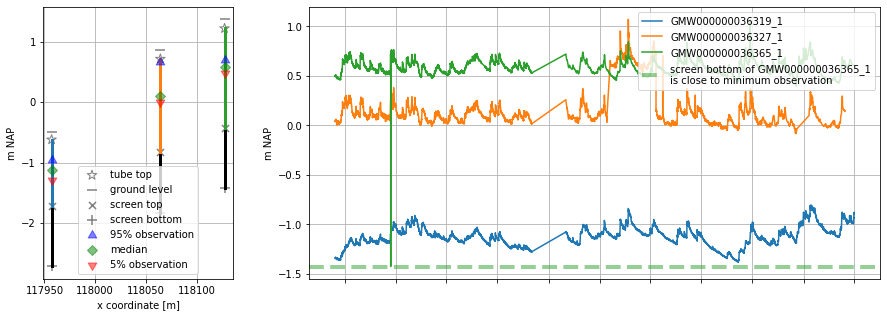

In [23]:
# plot wells, use x-coordinate in section plot
oc.plots.section_plot(section_colname_x="x", section_label_x="x coordinate [m]");

## Write ObsCollections<a id=writeOC></a>

Sometimes reading ObsCollections can be time consuming, especially when you need to download a lot of data. It can be worth to save the ObsCollection to a file and read it later instead of going through the full read process again. There are two basic ways to do this:
1. Write the ObsCollection to a pickle
2. Write the ObsCollection to an excel file

|                | pickle | excel                                       |
|----------------|--------|---------------------------------------------|
| extension      | .pklz  | .xlsx                                       |
| human readable | No     | Yes                                         |
| data lost      | None   | Some metadata, see `hpd.to_excel` docstring |

##### Pickle
Pickling is used to store Python objects into a binary file that is not human readable. Writing and reading a pickle is fast and returns an exact copy of the ObsCollection. Exchanging pickles between machines can be troublesome because of machine settings and differences between package versions.

In [24]:
oc.to_pickle("test.pklz")

In [25]:
oc_pickled = hpd.read_pickle("test.pklz")

##### Excel
An ObsCollection can be written to Excel file. An Excel file with multiple sheets is created. One sheet with the metdata and another sheet for each observation in the ObsCollection. Writing to an excel file is considerably slower than writing a pickle but it does give you a human readable file format that can be easily exchanged between machines.

In [30]:
oc.to_excel("test.xlsx")

In [31]:
oc_excelled = hpd.read_excel("test.xlsx")